> LoRA Parameter Efficient Fine-Tuning Project for Harvard CS 2420: Computing at Scale (Fall 2024)


---

### **Setup**

---

In [ ]:
!nvidia-smi

Thu Oct 10 01:13:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              46W / 400W |   1079MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import sys
import time
import os
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from copy import deepcopy

from torch.autograd import Variable

In [ ]:
# tracks the highest accuracy observed so far
best_acc = 0

def moving_average(a, n=100):
    '''Helper function used for visualization'''
    ret = torch.cumsum(torch.Tensor(a), 0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def train(net, epoch, loader, criterion, optimizer, loss_tracker = [], acc_tracker = []):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # update optimizer state
        optimizer.step()
        # compute average loss
        train_loss += loss.item()
        loss_tracker.append(loss.item())
        loss = train_loss / (batch_idx + 1)
        # compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        # Print status
        sys.stdout.write(f'\rEpoch {epoch}: Train Loss: {loss:.3f}' +
                         f'| Train Acc: {acc:.3f}')
        sys.stdout.flush()
    acc_tracker.append(acc)
    sys.stdout.flush()

def test(net, epoch, loader, criterion, loss_tracker = [], acc_tracker = []):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            loss_tracker.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()

    # Save checkpoint
    acc = 100.*correct/total
    acc_tracker.append(acc)
    if acc > best_acc:
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    '''
    A nn.Sequential layer executes its arguments in sequential order. In
    this case, it performs Conv2d -> BatchNorm2d -> ReLU. This is a typical
    block of layers used in Convolutional Neural Networks (CNNs). The
    ConvNet implementation below stacks multiple instances of this three layer
    pattern in order to achieve over 90% classification accuracy on CIFAR-10.
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    '''
    A 9 layer CNN using the conv_block function above. Again, we use a
    nn.Sequential layer to build the entire model. The Conv2d layers get
    progressively larger (more filters) as the model gets deeper. This
    corresponds to spatial resolution getting smaller (via the stride=2 blocks),
    going from 32x32 -> 16x16 -> 8x8. The nn.AdaptiveAvgPool2d layer at the end
    of the model reduces the spatial resolution from 8x8 to 1x1 using a simple
    average across all the pixels in each channel. This is then fed to the
    single fully connected (linear) layer called classifier, which is the output
    prediction of the model.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        '''
        The forward function is called automatically by the model when it is
        given an input image. It first applies the 8 convolution layers, then
        finally the single classifier layer.
        '''
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

---

### **Parameter Efficient Fine-tuning with LoRA**

---

Here I modified a model to enable parameter efficient fine-tuning (PEFT).
We will combine two techniques: freezing portions of a model, and applying low-rank updates.


Specifically, I used the library from [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).
We recommend reading Section 4 as it describes the method in detail.
LoRA can decrease the computation and memory requirements during training by reducing the number of parameters updated.

Instead of simply applying a full update $\Delta W$ to a frozen weight matrix $W_0 \in R^{d \times k}$, we can represent that update using low-rank decomposition. Namely, $\Delta W = BA$, where $B \in R^{d \times r}$ , $ A \in R^{r \times k}$, and the rank $r << min(d, k)$, resulting in:

$$
W_0 + \Delta W = W_0 + BA
$$

As we are using *low-rank approximation*, it would be more precise to state that $\Delta W \approx BA$, resulting in:

$$
W_0 + \Delta W \approx W_0 + BA
$$


Here I created a partially frozen network that applies low-rank updates to a classifier when training on a new [dataset](https://datashare.ed.ac.uk/handle/10283/3192).

In summary, I:
1. Loadedpre-trained ResNet-18
2. Modified the network to have frozen early layers
3. Further modified the network to have a LoRA classifier layer
4. Compared the fine-tuning performance of: unfrozen, partially frozen, and partially frozen + LoRA models

In [ ]:
!mkdir -p data/cinic-10
!curl -L https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz | tar xz -C data/cinic-10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   161  100   161    0     0    199      0 --:--:-- --:--:-- --:--:--   199
100  655M  100  655M    0     0  4935k      0  0:02:16  0:02:16 --:--:-- 2047k


In [ ]:
cinic_traindir = os.path.join("data", "cinic-10", "train")
cinic_testdir = os.path.join("data", "cinic-10", "test")

cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
cinic_normalize = transforms.Normalize(mean=cinic_mean, std=cinic_std)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

c_trainset = datasets.ImageFolder(root=cinic_traindir, transform=train_transform)
c_trainloader = torch.utils.data.DataLoader(c_trainset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

c_testset = datasets.ImageFolder(root=cinic_testdir, transform=transform)
c_testloader = torch.utils.data.DataLoader(c_testset,
                                         batch_size=100,
                                         shuffle=True,
                                         num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
!pip install loralib
import loralib as lora

device = 'cuda'
default_criterion = nn.CrossEntropyLoss
default_epochs = 10
default_lr = 0.01

In [ ]:
# https://pytorch.org/vision/stable/models.html
# Create a Resnet-18 network with weights that were pretrained on IMAGENET1K_V.
from torchvision.models import resnet18 # [ must import resnet18]
pt_net = resnet18(weights='IMAGENET1K_V1')

pt_net_criterion = default_criterion()
pt_net_optimizer = torch.optim.SGD(pt_net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Get the baseline accuracy
pt_net.to(device)
test(net=pt_net, epoch=0, loader=c_testloader, criterion=pt_net_criterion, loss_tracker=[], acc_tracker=[])

 | Test Loss: 10.426 | Test Acc: 0.017


In [ ]:
net_freeze = deepcopy(pt_net)

for name, param in net_freeze.named_parameters():
    if name not in ['layer4.0.conv1.weight','layer4.0.conv2.weight','layer4.1.conv1.weight','layer4.1.conv2.weight','fc.weight']:
        param.requires_grad = False

net_freeze_criterion = default_criterion()
net_freeze_optimizer = torch.optim.SGD(net_freeze.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Get the baseline accuracy
net_freeze.to(device)
test(net=net_freeze, epoch=0, loader=c_testloader, criterion=net_freeze_criterion, loss_tracker=[], acc_tracker=[])

 | Test Loss: 10.426 | Test Acc: 0.017


In [ ]:
# Replace the classifer layer with a LoRA linear layer

net_freeze_lora = deepcopy(net_freeze)

# Modify network to have a LoRA linear classifer
saved_fc_weights = net_freeze_lora.fc.weight.clone()
for name, param in net_freeze.named_parameters():
  if name == 'fc.weight':
    print(param.shape)
#after replacing with LoRA layer, set and freeze weights based on original weights
net_freeze_lora.fc = lora.Linear(in_features=512, out_features=1000,r=10)
net_freeze_lora.fc.weight = nn.Parameter(saved_fc_weights)
net_freeze_lora.fc.weight.requires_grad = False

net_freeze_lora_criterion = default_criterion()
net_freeze_lora_optimizer = torch.optim.SGD(net_freeze_lora.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

net_freeze_lora.to(device)
test(net=net_freeze_lora, epoch=0, loader=c_testloader, criterion=net_freeze_lora_criterion, loss_tracker=[], acc_tracker=[])

torch.Size([1000, 512])
 | Test Loss: 10.429 | Test Acc: 0.017


In [ ]:
# Fine-tune and test vanilla pre-trained network
pt_net.to(device)
vanilla_train_loss_tracker, vanilla_test_acc_tracker = [], []
for epoch in range(default_epochs):
    train(net=pt_net, epoch=epoch, loader=c_trainloader,
          criterion=pt_net_criterion, optimizer=pt_net_optimizer,
          loss_tracker=vanilla_train_loss_tracker, acc_tracker=[])
    test(net=pt_net, epoch=epoch, loader=c_testloader,
         criterion=pt_net_criterion,
         loss_tracker=[], acc_tracker=vanilla_test_acc_tracker)


Epoch 0: Train Loss: 1.533| Train Acc: 45.542 | Test Loss: 1.237 | Test Acc: 55.734
Epoch 1: Train Loss: 1.139| Train Acc: 59.586 | Test Loss: 1.118 | Test Acc: 60.791
Epoch 2: Train Loss: 1.042| Train Acc: 63.003 | Test Loss: 1.013 | Test Acc: 64.659
Epoch 3: Train Loss: 0.980| Train Acc: 65.283 | Test Loss: 0.960 | Test Acc: 66.167
Epoch 4: Train Loss: 0.936| Train Acc: 66.873 | Test Loss: 0.920 | Test Acc: 67.458
Epoch 5: Train Loss: 0.904| Train Acc: 68.027 | Test Loss: 0.963 | Test Acc: 65.940
Epoch 6: Train Loss: 0.886| Train Acc: 68.550 | Test Loss: 0.915 | Test Acc: 67.960
Epoch 7: Train Loss: 0.858| Train Acc: 69.458 | Test Loss: 0.904 | Test Acc: 68.180
Epoch 8: Train Loss: 0.846| Train Acc: 69.949 | Test Loss: 0.922 | Test Acc: 67.638
Epoch 9: Train Loss: 0.825| Train Acc: 70.636 | Test Loss: 0.913 | Test Acc: 68.188


In [ ]:
# Fine-tune and test partially frozen network
net_freeze.to(device)
frozen_train_loss_tracker, frozen_test_acc_tracker = [], []
for epoch in range(default_epochs):
    train(net=net_freeze, epoch=epoch, loader=c_trainloader,
          criterion=net_freeze_criterion, optimizer=net_freeze_optimizer,
          loss_tracker=frozen_train_loss_tracker, acc_tracker=[])
    test(net=net_freeze, epoch=epoch,
         loader=c_testloader, criterion=net_freeze_criterion,
         loss_tracker=[], acc_tracker=frozen_test_acc_tracker)


Epoch 0: Train Loss: 1.675| Train Acc: 41.963 | Test Loss: 2.047 | Test Acc: 44.626
Epoch 1: Train Loss: 1.405| Train Acc: 49.753 | Test Loss: 1.453 | Test Acc: 51.449
Epoch 2: Train Loss: 1.346| Train Acc: 51.876 | Test Loss: 1.725 | Test Acc: 50.763
Epoch 3: Train Loss: 1.303| Train Acc: 53.124 | Test Loss: 1.315 | Test Acc: 54.207
Epoch 4: Train Loss: 1.272| Train Acc: 54.346 | Test Loss: 1.458 | Test Acc: 53.226
Epoch 5: Train Loss: 1.249| Train Acc: 55.109 | Test Loss: 1.272 | Test Acc: 54.543
Epoch 6: Train Loss: 1.241| Train Acc: 55.542 | Test Loss: 1.426 | Test Acc: 54.481
Epoch 7: Train Loss: 1.217| Train Acc: 56.442 | Test Loss: 1.407 | Test Acc: 54.688
Epoch 8: Train Loss: 1.209| Train Acc: 56.516 | Test Loss: 1.456 | Test Acc: 53.576
Epoch 9: Train Loss: 1.194| Train Acc: 57.023 | Test Loss: 1.336 | Test Acc: 55.333


In [ ]:
# Fine-tune and test partially frozen network with LoRA classifier
net_freeze_lora.to(device)
lora_train_loss_tracker, lora_test_acc_tracker = [], []
for epoch in range(default_epochs):
    train(net=net_freeze_lora, epoch=epoch, loader=c_trainloader,
          criterion=net_freeze_lora_criterion, optimizer=net_freeze_lora_optimizer,
          loss_tracker=lora_train_loss_tracker, acc_tracker=[])
    test(net=net_freeze_lora, epoch=epoch,
         loader=c_testloader, criterion=net_freeze_lora_criterion,
         loss_tracker=[], acc_tracker=lora_test_acc_tracker)

Epoch 0: Train Loss: 1.990| Train Acc: 43.394 | Test Loss: 1.468 | Test Acc: 49.086
Epoch 1: Train Loss: 1.415| Train Acc: 50.316 | Test Loss: 1.438 | Test Acc: 51.520
Epoch 2: Train Loss: 1.335| Train Acc: 52.543 | Test Loss: 1.385 | Test Acc: 53.177
Epoch 3: Train Loss: 1.287| Train Acc: 54.014 | Test Loss: 1.294 | Test Acc: 54.029
Epoch 4: Train Loss: 1.258| Train Acc: 54.922 | Test Loss: 1.380 | Test Acc: 54.490
Epoch 5: Train Loss: 1.248| Train Acc: 55.572 | Test Loss: 1.340 | Test Acc: 53.924
Epoch 6: Train Loss: 1.238| Train Acc: 55.750 | Test Loss: 1.278 | Test Acc: 55.721
Epoch 7: Train Loss: 1.227| Train Acc: 56.136 | Test Loss: 1.251 | Test Acc: 55.778
Epoch 8: Train Loss: 1.201| Train Acc: 56.788 | Test Loss: 1.246 | Test Acc: 55.869
Epoch 9: Train Loss: 1.188| Train Acc: 57.586 | Test Loss: 1.238 | Test Acc: 56.648


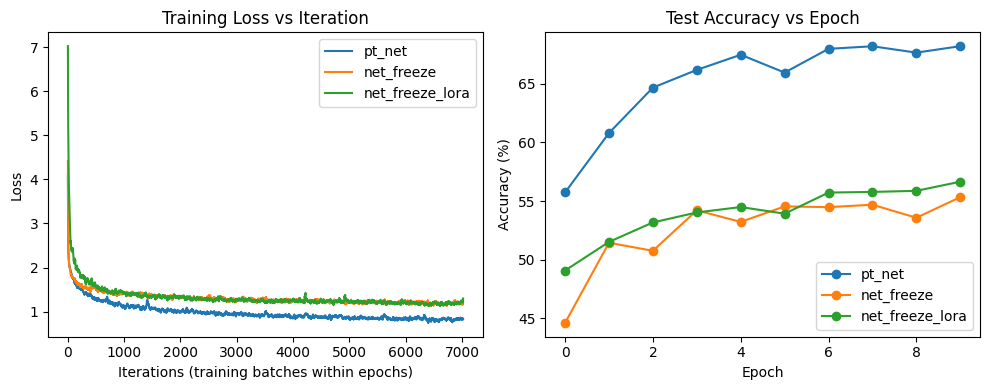

In [ ]:
plt.figure(figsize=(10, 4))
# plot training loss
plt.subplot(1, 2, 1)
plt.plot(moving_average(vanilla_train_loss_tracker,n=20), label='pt_net')
plt.plot(moving_average(frozen_train_loss_tracker,n=20), label='net_freeze')
plt.plot(moving_average(lora_train_loss_tracker,n=20), label='net_freeze_lora')
plt.legend()
plt.title('Training Loss vs Iteration')
plt.xlabel('Iterations (training batches within epochs)')
plt.ylabel('Loss')

# plot test acc
plt.subplot(1, 2, 2)
plt.plot(range(default_epochs), vanilla_test_acc_tracker, label = 'pt_net', marker='o')
plt.plot(range(default_epochs), frozen_test_acc_tracker, label = 'net_freeze', marker='o')
plt.plot(range(default_epochs), lora_test_acc_tracker, label = 'net_freeze_lora', marker='o')
plt.legend()
plt.title('Test Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()